>Time Varying Covariates

In [11]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import scipy.special as sc
import os
from IPython.display import display, Image
import plotly.graph_objs as go
from patsy import dmatrices

# Functions

In [459]:
def compute_period(betas, c, X, Week):
    """Computes the covariate and duration dependence adjusted period

    Args:
        betas (list): list of coefficients for each covariate
        c (float): duration dependence parameter
        X (dataframe): dataframe with covariates
        Week (panda Series): week index
        
    Returns:
        A array of numbers with each value representing how much adjusted times
        has passed after each Week.

    Raises:
    """
    exps = np.array(np.exp(np.sum((X * betas),axis = 1)))
    duration_dep = np.array(list((Week ** c)[0:1]) + list((Week ** c).diff()[1:]))
    period = np.cumsum(duration_dep*exps)
    return period

def compute_probabilities(alpha, r, c, betas, X, Week):
    """Computes the cumulative probability at each period

    Args:
        alpha (float): scale parameter
        r (float): heterogeniety parameter        
        c (float): duration dependence parameter
        betas (list): list of coefficients for each covariate
        X (dataframe): dataframe with covariates
        Week (panda Series): week index
        
    Returns:
        A array of probabilities representing the cumulative 
        probability of an event happening at each period

    Raises:
    """
    period = compute_period(betas, c, X, Week)
    p = []
    for t in np.arange(len(period)):
        p.append(1 - (alpha / (alpha + period[t]))**r)
    return p

def log_likelihood(alpha, r, c, betas, inc_trl, panel_size, X, Week):
    """Objective function to be optimized
    
    Args:
        alpha (float): scale parameter
        r (float): heterogeniety parameter        
        c (float): duration dependence parameter
        betas (list): list of coefficients for each covariate
        inc_trl (panda Series): incremental number of trial per week index
        panel_size (int): number of total individual observed
        X (dataframe): dataframe with covariates
        Week (panda Series): week index
        
    Returns:
        Log Likelihood of observing such parameter given that data

    Raises:
    """
    if alpha <= 0 or r <= 0 or c <= 0:
        return -99999
    cumu_prob = np.array(compute_probabilities(alpha, r, c, betas, X, Week))
    
    # Compute between period probs
    probabilities = [cumu_prob[0]]
    for i in np.arange(1, len(cumu_prob)):
        probabilities.append(cumu_prob[i] - cumu_prob[i - 1])  
    
    ll = np.sum(np.array(inc_trl) * np.array(np.log(probabilities))) + \
    (panel_size - np.sum(inc_trl)) * np.log(1 - cumu_prob[-1])

    return ll

def maximize(expr, data, Week, panel_size, duration_dep):
    """Optimize the parameters

    Args:
        expr (string): Target Variable ~ Covariate
        data (dataframe): holdout dataframe
        Week (panda Series): week index
        panel_size (int): number of total individual observed
        duration_dep (boolean): do we allow for duration dependence
        
    Returns:
        Optimized parameters and log likelihood

    Raises:
    """
    Y,X = dmatrices(expr, data, return_type='dataframe')
    X = X.iloc[:,1:]
    Y = Y.Inc_HH.to_list()
    period = compute_period
    if (duration_dep):
        func = lambda x: -log_likelihood(x[0], x[1], x[2], x[3:], Y, panel_size, X, Week)
        x0 = np.array([1, 1, 1] + [0] * X.shape[1])
        bnds = ((0.00001, None), (0.00001, None), (0.00001, None)) + ((None, None),) * X.shape[1]
        res = minimize(func, x0, method= "SLSQP",bounds=bnds)
        return res.x, res.fun
    
    func = lambda x: -log_likelihood(x[0], x[1], 1, x[2:], Y, panel_size, X, Week)
    x0 = np.array([1, 1] + [0] * X.shape[1])
    bnds = ((0.00001, None), (0.00001, None)) + ((None, None),) * X.shape[1]
    res = minimize(func, x0, method= "SLSQP",bounds=bnds)
    return res.x, res.fun

def forecast(expr, holdout_data, full_data, holdout_Week, panel_size, duration_dep, num_periods):
    """Forecasts cumulative count

    Args:
        expr (string): Target Variable ~ Covariate
        holdout_data (dataframe): holdout dataframe
        full_data (dataframe): complete dataframe
        holdout_Week (panda Series): holdout week index
        panel_size (int): number of total individual observed
        duration_dep (boolean): do we allow for duration dependence
        num_periods (int): number of periods to be forecasted
        
    Returns:
        list of number representing the forecasts

    Raises:
    """
    if (duration_dep):
        params = maximize(expr, holdout_data, holdout_Week, panel_size, duration_dep)[0]
        alpha = params[0]
        r = params[1]
        c = params[2]
        betas = params[3:]
        num_periods_array = pd.Series(np.arange(1, num_periods + 1))
        
        Y,X = dmatrices(expr, full_data, return_type='dataframe')
        X = X.iloc[:,1:]
        probabilities = compute_probabilities(alpha, r, c, betas, X, num_periods_array)
        e = []
        for i in np.arange(num_periods):
            e.append(panel_size * probabilities[i])
        return e
    
    params = maximize(expr, holdout_data, holdout_Week, panel_size, duration_dep)[0]
    alpha = params[0]
    r = params[1]
    betas = params[2:]
    num_periods_array = pd.Series(np.arange(1, num_periods + 1))

    Y,X = dmatrices(expr, full_data, return_type='dataframe')
    X = X.iloc[:,1:]
    probabilities = compute_probabilities(alpha, r, 1, betas, X, num_periods_array)
    e = []
    for i in np.arange(num_periods):
        e.append(panel_size * probabilities[i])
    return e

## Example

In [460]:
data = pd.read_csv("data/KB covariate models.csv")
data = data.iloc[:,[0,1,3,4]]
data.columns = ['Week','Cum_HH','Coupon','AnyP']
data['Inc_HH'] = list(data.Cum_HH[0:1]) + list(data.Cum_HH.diff()[1:])

In [461]:
expr = "Inc_HH ~ 1"
Y,X = dmatrices(expr, data, return_type='dataframe')
X = X.iloc[:,1:]

In [462]:
expr = "Inc_HH ~ Coupon + AnyP"

print(maximize(expr, data.iloc[0:24,:], data.Week[0:24], 1499, False))
eg_cov = forecast(expr, data.iloc[0:24,:],data, data.Week[0:24],1499,False,52)

print(maximize(expr, data.iloc[0:24,:], data.Week[0:24], 1499, True))
wg_cov = forecast(expr, data.iloc[0:24,:],data, data.Week[0:24],1499,True,52)

/Users/davidfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning:

divide by zero encountered in log

/Users/davidfan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning:

invalid value encountered in multiply



(array([5.49091903e+01, 1.03130312e-01, 2.31047676e+00, 1.49124019e-02]), 674.0058483731035)
(array([9.65803481e+02, 2.15784080e+00, 8.17193451e-01, 3.15511653e+00,
       1.49537350e-02]), 673.5900920294705)


In [463]:
expr = "Inc_HH ~ 1"

print(maximize(expr, data.iloc[0:24,:], data.Week[0:24], 1499, False))
eg = forecast(expr, data.iloc[0:24,:],data, data.Week[0:24],1499,False,52)

print(maximize(expr, data.iloc[0:24,:], data.Week[0:24], 1499, True))
wg = forecast(expr, data.iloc[0:24,:],data, data.Week[0:24],1499,True,52)

(array([7.97299761, 0.05024319]), 681.3729499388786)
(array([6.1993001 , 0.03126247, 1.24055989]), 680.9982764221018)


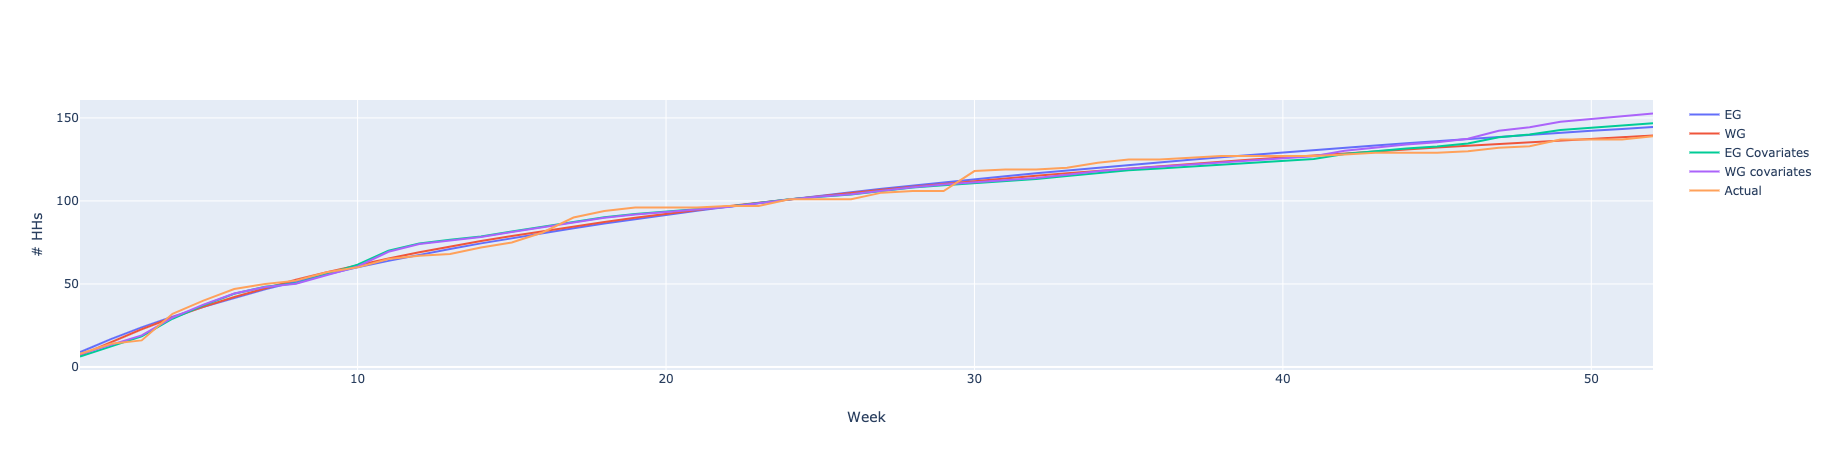

In [464]:
fig = go.Figure()

# Pareto II
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=eg,
        mode='lines',
        name='EG',
    )
)

# Weibull
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=wg,
        mode='lines',
        name='WG')
)

# Pareto II
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=eg_cov,
        mode='lines',
        name='EG Covariates',
    )
)

# Weibull
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=wg_cov,
        mode='lines',
        name='WG covariates')
)

# Observed
fig.add_trace(
    go.Scatter(
        x=data.Week.to_list(),
        y=data.Cum_HH,
        mode='lines',
        name='Actual')
)

# Plot labels
fig.update_layout(title='',
                  xaxis_title='Week',
                  yaxis_title='# HHs',
                  annotations=[      
                  ],
                )

fig.show()